# Segmentación

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
### Kmedias
from sklearn.cluster import KMeans
##Metricas
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
## visualización
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer

# Cargar los datos

In [41]:
url="https://raw.githubusercontent.com/Cruzalirio/Ucentral/master/Bases/CAL-ANOMALIAS.txt"
clientes=pd.read_csv(url, sep=",")
clientes

,id,name,region,farmsize,rainfall,landquality,farmincome,maincrop,claimtype,claimvalue
0,id601,name601,midlands,1480,30,8,330729.0,wheat,decommission_land,74703.1
1,id602,name602,north,1780,42,9,734118.0,maize,arable_dev,245354.0
2,id603,name603,midlands,500,69,7,231965.0,rapeseed,decommission_land,84213.0
3,id604,name604,southwest,1860,103,3,625251.0,potatoes,decommission_land,281082.0
4,id605,name605,north,1700,46,8,621148.0,wheat,decommission_land,122006.0
...,...,...,...,...,...,...,...,...,...,...
295,id896,name896,southeast,1120,15,5,81314.9,wheat,arable_dev,24486.1
296,id897,name897,midlands,580,27,4,60611.2,rapeseed,arable_dev,17374.7
297,id898,name898,southeast,1540,76,8,876316.0,potatoes,arable_dev,277091.0
298,id899,name899,north,480,35,5,81609.4,rapeseed,arable_dev,24734.2


## Paso 1 

Describir los datos


In [3]:
clientes.describe()

,farmsize,rainfall,landquality,farmincome,claimvalue
count,300.000000,300.000000,300.000000,3.000000e+02,300.000000
mean,1210.066667,66.183333,6.120000,4.791345e+05,146712.907133
std,450.808262,27.808405,2.008077,3.375823e+05,110467.735776
min,400.000000,15.000000,3.000000,4.789850e+04,9371.140000
25%,835.000000,43.750000,4.000000,2.311512e+05,69300.400000
50%,1240.000000,70.000000,6.000000,3.936605e+05,113505.000000
75%,1600.000000,90.000000,8.000000,6.251610e+05,192251.750000
max,1980.000000,109.000000,9.000000,1.649820e+06,609803.000000


In [43]:
clientes.groupby("region").size()

region
midlands      93
north         39
southeast    125
southwest     43
dtype: int64

In [44]:
clientes.groupby("maincrop").size()

maincrop
maize        91
potatoes     41
rapeseed     49
wheat       119
dtype: int64

In [45]:
clientes.groupby("claimtype").size()

claimtype
arable_dev           123
decommission_land    177
dtype: int64

Colocar en un tabla y explicar de manera muy somera.

## Preprocesamiento

1. One Hot Encoding para las variables region, maincrop y claimtype
2. Estandarización para las variables farmsize, rainfall, landquality, faircome y claimvalue

$$VariableNueva = \frac{x-\bar{x}}{s_x}$$

In [46]:
## Este es un comentario
cuali = clientes[['region', 'maincrop', 'claimtype']]
cuanti = clientes[[ 'farmsize', 'rainfall', 'landquality',
       'farmincome','claimvalue']]
cuali_01 = pd.get_dummies(cuali, drop_first=True)
escala=StandardScaler(with_mean=True, with_std=True)
escala.fit(cuanti)
cuanti_estan=escala.transform(cuanti)

clientes_completos = pd.concat([cuali_01, pd.DataFrame(cuanti_estan, index=cuanti.index, columns=cuanti.columns)], axis=1)
clientes_completos

,region_north,region_southeast,region_southwest,maincrop_potatoes,maincrop_rapeseed,maincrop_wheat,claimtype_decommission_land,farmsize,rainfall,landquality,farmincome,claimvalue
0,0,0,0,0,0,1,1,0.599777,-1.303339,0.937783,-0.440347,-0.652952
1,1,0,0,0,0,0,0,1.266360,-0.871094,1.436604,0.756584,0.894432
2,0,0,0,0,1,0,1,-1.577729,0.101458,0.438962,-0.733399,-0.566721
3,0,0,1,1,0,0,1,1.444116,1.326152,-1.556321,0.433555,1.218397
4,1,0,0,0,0,1,1,1.088605,-0.727012,0.937783,0.421381,-0.224031
...,...,...,...,...,...,...,...,...,...,...,...,...
295,0,1,0,0,0,1,0,-0.200123,-1.843646,-0.558679,-1.180406,-1.108297
296,0,0,0,0,1,0,0,-1.399973,-1.411401,-1.057500,-1.241838,-1.172780
297,0,1,0,1,0,0,0,0.733093,0.353601,0.937783,1.178513,1.182209
298,1,0,0,0,1,0,0,-1.622167,-1.123237,-0.558679,-1.179532,-1.106047


## Kmedias

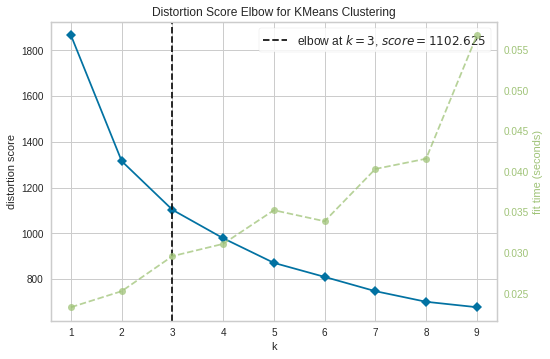

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [47]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(clientes_completos)      # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [48]:
## Indice de silueta
## De 2 a 20 grupos
num_clusters = np.arange(2,20)
results = {}
for size in num_clusters:
    model = KMeans(n_clusters = size, n_init=10).fit(clientes_completos)
    predictions = model.predict(clientes_completos)
    results[size] = silhouette_score(clientes_completos, predictions)
best_size = max(results, key=results.get)
results

{2: 0.27698121980069684,
 3: 0.20111454309009802,
 4: 0.19032116301815755,
 5: 0.20065909636196214,
 6: 0.1793631305740337,
 7: 0.18676961377240364,
 8: 0.1788168993942765,
 9: 0.1612868309950386,
 10: 0.16102242886038493,
 11: 0.14899049481955276,
 12: 0.15269323471894647,
 13: 0.14834349529674992,
 14: 0.14740017866619223,
 15: 0.15670640395969176,
 16: 0.14800086842729848,
 17: 0.1449077788634516,
 18: 0.14753445978383117,
 19: 0.14968136508441798}

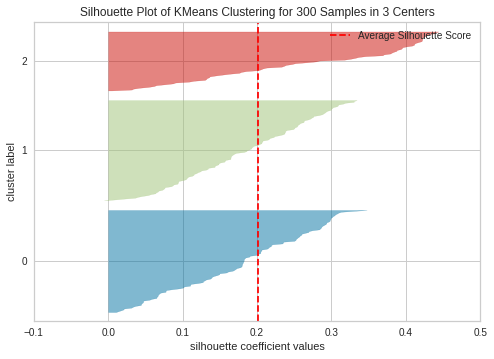

SilhouetteVisualizer(ax=<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 300 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>,
                     colors='yellowbrick',
                     estimator=KMeans(n_clusters=3, n_init=10))

In [49]:
silhouette_visualizer(KMeans(3, n_init=10), clientes_completos, colors='yellowbrick')

## Nos quedamos con 3 grupos

In [50]:
#### la definitiva
kmedias=KMeans(n_clusters=3, n_init=10).fit(clientes_completos) ### Salieron los grupos, ahora visualizar
kmedias.labels_
### Las etiquetas a cada individuo
clientes["Grupo"]=kmedias.labels_
clientes

,id,name,region,farmsize,rainfall,landquality,farmincome,maincrop,claimtype,claimvalue,Grupo
0,id601,name601,midlands,1480,30,8,330729.0,wheat,decommission_land,74703.1,0
1,id602,name602,north,1780,42,9,734118.0,maize,arable_dev,245354.0,2
2,id603,name603,midlands,500,69,7,231965.0,rapeseed,decommission_land,84213.0,1
3,id604,name604,southwest,1860,103,3,625251.0,potatoes,decommission_land,281082.0,2
4,id605,name605,north,1700,46,8,621148.0,wheat,decommission_land,122006.0,0
...,...,...,...,...,...,...,...,...,...,...,...
295,id896,name896,southeast,1120,15,5,81314.9,wheat,arable_dev,24486.1,0
296,id897,name897,midlands,580,27,4,60611.2,rapeseed,arable_dev,17374.7,0
297,id898,name898,southeast,1540,76,8,876316.0,potatoes,arable_dev,277091.0,2
298,id899,name899,north,480,35,5,81609.4,rapeseed,arable_dev,24734.2,0


In [51]:
clientes.groupby("Grupo").size()

Grupo
0    115
1    117
2     68
dtype: int64

## Descripción de los grupos

1. Para las cualitativas

In [52]:
clientes.groupby("Grupo").mean()
### De acá sañe tu discusión de los grupos

,farmsize,rainfall,landquality,farmincome,claimvalue
Grupo,,,,,
0,1206.434783,36.000000,6.173913,257896.222609,78934.507304
1,1002.222222,84.461538,5.213675,400794.275214,119292.682051
2,1573.823529,85.779412,7.588235,988078.720588,308517.058824


In [25]:
clientes[[ 'farmsize', 'Grupo']].groupby("Grupo").describe()

farmsize                                                                
         count         mean         std    min     25%     50%     75%     max
Grupo                                                                         
0        117.0  1002.222222  403.004045  400.0   680.0   940.0  1320.0  1940.0
1         68.0  1573.823529  308.007702  720.0  1395.0  1660.0  1820.0  1960.0
2        115.0  1206.434783  434.434885  440.0   840.0  1240.0  1580.0  1980.0

In [54]:
fig=px.box(clientes.sort_values("Grupo"), y="farmsize", color="Grupo")
fig.show()

In [26]:
clientes[['rainfall', 'Grupo']].groupby("Grupo").describe()

rainfall                                                      
         count       mean        std   min   25%   50%    75%    max
Grupo                                                               
0        117.0  84.461538  15.023280  56.0  73.0  83.0  98.00  109.0
1         68.0  85.779412  16.400624  42.0  76.0  89.0  99.25  109.0
2        115.0  36.000000  12.228095  15.0  26.0  37.0  46.00   61.0

In [55]:
fig=px.box(clientes.sort_values("Grupo"), y="rainfall", color="Grupo")
fig.show()

In [27]:
clientes[['landquality', 'Grupo']].groupby("Grupo").describe()

landquality                                             
            count      mean       std  min  25%  50%  75%  max
Grupo                                                         
0           117.0  5.213675  1.765713  3.0  4.0  5.0  6.0  9.0
1            68.0  7.588235  1.528196  3.0  7.0  8.0  9.0  9.0
2           115.0  6.173913  1.974668  3.0  4.0  6.0  8.0  9.0

In [56]:
fig=px.box(clientes.sort_values("Grupo"), y='landquality', color="Grupo")
fig.show()

In [28]:
clientes[[ 'farmincome', 'Grupo']].groupby("Grupo").describe()

farmincome                                                              \
           count           mean            std       min       25%       50%   
Grupo                                                                          
0          117.0  400794.275214  155442.542622   98131.2  286209.0  394465.0   
1           68.0  988078.720588  266280.178112  554413.0  775115.5  922329.5   
2          115.0  257896.222609  149870.437335   47898.5  128614.5  235813.0   

                             
             75%        max  
Grupo                        
0       505950.0   756755.0  
1      1154222.5  1649820.0  
2       355031.0   621148.0

In [57]:
fig=px.box(clientes.sort_values("Grupo"), y='farmincome', color="Grupo")
fig.show()

In [29]:
clientes[['claimvalue', 'Grupo']].groupby("Grupo").describe()

claimvalue                                                      \
           count           mean            std        min        25%   
Grupo                                                                  
0          117.0  119292.682051   53416.200623   22176.90   78431.40   
1           68.0  308517.058824  100695.358802  153275.00  242936.75   
2          115.0   78934.507304   46059.937208    9371.14   43990.75   

                                      
            50%        75%       max  
Grupo                                 
0      111198.0  158310.00  239596.0  
1      284674.0  348424.75  609803.0  
2       74545.1  106895.50  204204.0

In [58]:
fig=px.box(clientes.sort_values("Grupo"), y='claimvalue', color="Grupo")
fig.show()

## Para las cualitativas

In [60]:
tablaCont=pd.crosstab(clientes['region'],clientes['Grupo'].astype(str), normalize="columns")
tablaCont=tablaCont.stack().reset_index().rename(columns={0:'Porcentaje'})
fig=px.bar(tablaCont, x='Grupo', y='Porcentaje', color='region')
fig.show()

In [61]:
tablaCont=pd.crosstab(clientes['claimtype'],clientes['Grupo'].astype(str), normalize="columns")
tablaCont=tablaCont.stack().reset_index().rename(columns={0:'Porcentaje'})
fig=px.bar(tablaCont, x='Grupo', y='Porcentaje', color='claimtype')
fig.show()

In [62]:
tablaCont=pd.crosstab(clientes['maincrop'],clientes['Grupo'].astype(str), normalize="columns")
tablaCont=tablaCont.stack().reset_index().rename(columns={0:'Porcentaje'})
fig=px.bar(tablaCont, x='Grupo', y='Porcentaje', color='maincrop')
fig.show()

1. Las variables más importantes fueron: Extension de tierra, frecuencia de lluvias, los ingresos y el valor del reclamo.
2. EL grupo más problematico es el 2 porque reclama mucho, gana mucho y cree que sus tierras son buenas.